# Pipelines

Son un conjunto de "tuberias" que se crean con el objetivo de hacer segmentación de datos 

In [1]:
%load_ext watermark
%watermark

2020-09-15T10:07:22-05:00

CPython 3.7.6
IPython 7.13.0

compiler   : GCC 7.3.0
system     : Linux
release    : 5.4.0-47-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [2]:
import pandas as pd
import numpy as np

In [3]:
datos = pd.read_csv("datos_procesamiento.csv")

In [4]:
datos.head()

,col_inexistente1,col2,col3,col_outliers,col_outliers2,col_categorica,col_ordinal,col_texto,objetivo
0,59.0,52.0,2.232832,-50,0.771666,ratón,muy bien,Tenía en su casa una ama que pasaba de los cua...,1
1,31.0,74.0,0.906147,-5,1.068558,elefante,regular,"El resto della concluían sayo de velarte, calz...",0
2,81.0,28.0,0.626750,-32,0.846396,ratón,muy mal,"El resto della concluían sayo de velarte, calz...",0
3,34.0,16.0,0.816738,-84,0.637381,gato,mal,"Una olla de algo más vaca que carnero, salpicó...",0
4,32.0,28.0,0.571131,65,4.540614,gato,bien,Tenía en su casa una ama que pasaba de los cua...,0


In [5]:
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, feature_extraction

El objetivo de las tuberias es seguir el siguiente proceso de acuerdo a diferentes variables

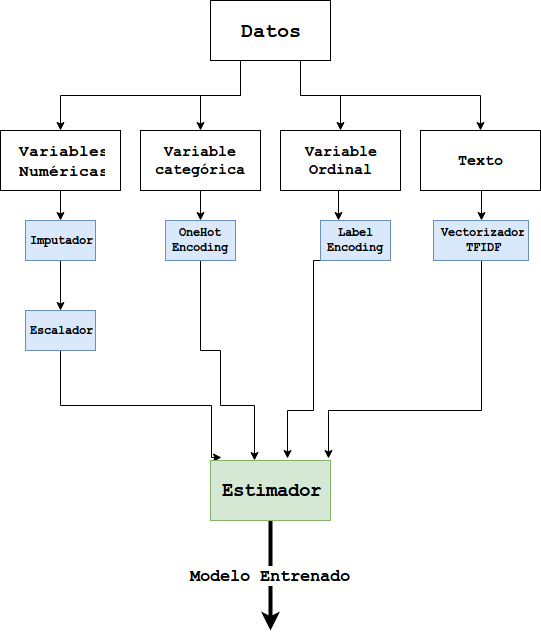

In [6]:
class BinarizadorCategorico(preprocessing.LabelBinarizer):
    def fit(self, X, y=None):
        super(BinarizadorCategorico, self).fit(X)
    
    def transform(self, X, y=None):
        return super(BinarizadorCategorico, self).transform(X)
    
    def fit_transform(self, X, y=None):
        return super(BinarizadorCategorico, self).fit(X).transform(X)
    
class CodificadorCategorico(preprocessing.LabelEncoder):
    
    def fit(self, X, y=None):
        super(CodificadorCategorico, self).fit(X)
        
    def transform(self, X, y=None):
        return super(CodificadorCategorico, self).transform(X)
    
    def fit_transform(self, X, y=None):
        return super(CodificadorCategorico, self).fit(X).transform(X)

In [7]:
from sklearn.linear_model import LogisticRegression

col_numericas = ["col_inexistente1", "col2", "col3", "col_outliers", "col_outliers2"]
col_categorica = ["col_categorica"]
col_texto = ["col_texto"]
col_ordinal = ["col_ordinal"]

imputador = SimpleImputer(strategy="mean")
escalador = preprocessing.StandardScaler()

transformador_ordinal = CodificadorCategorico()
transformador_categorico = BinarizadorCategorico()

transformador_texto = feature_extraction.text.TfidfVectorizer()

estimador = LogisticRegression()

In [8]:
transformador_categorico.fit_transform(datos[col_categorica])

array([[0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

Al utilizar el binarizador es mucho más rapido y sencillo que con **OneHotEncoder**

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
from sklearn.pipeline import Pipeline

Un pipeline se define como una secuencia de pasos. Cada paso se define con una tupla de forma [nombre del paso, transformador] 

Por ejemplo si quisiera crear un pipeline que procese las variables numericas primero imputandolas y luego estandarizandolas, podriamos crear un pipeline de la siguiente forma 

In [11]:
transformador_numerico = Pipeline(
    [("imputador", imputador),("escalador", escalador)]
)

In [12]:
transformador_numerico.fit_transform(datos[col_numericas])

array([[ 0.39921733,  0.08280686,  0.44281884, -0.69460006, -0.03836537],
       [-0.65360504,  0.86133291, -0.32339035, -0.11846597, -0.03827803],
       [ 1.22643491, -0.76649428, -0.4847522 , -0.46414642, -0.03834338],
       ...,
       [-1.10481463,  0.11819441, -0.42094381,  0.88016644, -0.03819664],
       [ 1.48964051,  1.56908386, -0.4077454 ,  0.81615154, -0.03818958],
       [ 1.7152453 ,  0.22435705, -0.13638793,  0.72653069, -0.03831468]])

Debemos hacer que el transformador varie en función de las columnas y que el pipeline falla si le damos una columna categorica o de texto. Para esto debemos crear una clase que herede de TransformerMixin y que tenga el metodo transform

In [13]:
from sklearn.base import TransformerMixin

class TransformadorBase(TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X,y=None):
        return self
    
    def transform(self, X, y=None):
        return X

In [14]:
from sklearn.base import BaseEstimator

from scipy.sparse import issparse

class DenseTransformer(BaseEstimator):
    
    def __init__(self, return_copy=True):
        self.return_copy = return_copy
        self.is_fitted = False
    
    def transform(slef, X, y=None):
        if issparse(X):
            return X.toarray()
        elif self.return_copy:
            return X.copy()
        else:
            return X
    
    def fit(self, X, y):
        self.is_fitted = True
        return self
    
class ColumnExtractor(TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        
    def transform(self, X, **transform_params):
        return X[self.columns].values
    
    def fit(self, X, y=None, **fit_params):
        return self

Ahora si creamos un Column Extractor y le pasamos las columnas numericas tenemos un transformador que podemos usar en un pipeline y que selecciona un subgrupo de columnas como una matriz y así las puede trabajar

In [15]:
cext = ColumnExtractor(columns=col_numericas)

In [16]:
cext.fit_transform(datos)

array([[ 59.        ,  52.        ,   2.23283208, -50.        ,
          0.77166646],
       [ 31.        ,  74.        ,   0.90614714,  -5.        ,
          1.06855838],
       [ 81.        ,  28.        ,   0.62675042, -32.        ,
          0.84639576],
       ...,
       [ 19.        ,  53.        ,   0.73723413,  73.        ,
          1.34525201],
       [ 88.        ,  94.        ,   0.76008706,  68.        ,
          1.3692463 ],
       [ 94.        ,  56.        ,   1.2299403 ,  61.        ,
          0.94395714]])

Creamos los pipelines para cada tipo de variables

In [17]:
pipeline_numerico = Pipeline([
    ["selector_numerico", ColumnExtractor(columns=col_numericas)],
    ["transformador_numerico", transformador_numerico]
])

pipeline_numerico.fit_transform(datos)[:5]

array([[ 0.39921733,  0.08280686,  0.44281884, -0.69460006, -0.03836537],
       [-0.65360504,  0.86133291, -0.32339035, -0.11846597, -0.03827803],
       [ 1.22643491, -0.76649428, -0.4847522 , -0.46414642, -0.03834338],
       [-0.54080264, -1.19114485, -0.37502756, -1.12990136, -0.03840487],
       [-0.61600424, -0.76649428, -0.51687443,  0.77774261, -0.03725668]])

In [18]:
# Debemos convertirlo a una sola lista con el FunctionTransformer ya que el transformador de texto
# recibe un arreglo en una sola dimensión

pipeline_texto = Pipeline([
    ["selector_texto", ColumnExtractor(columns=col_texto)],
    ["transformador_dimension",preprocessing.FunctionTransformer(lambda x: x[:,0], validate=False)],
    ["transformador_texto", transformador_texto],
    ["texto_array", DenseTransformer()]
])

pipeline_texto.fit_transform(datos)[:5]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.20474512, 0.        , 0.        , 0.        , 0.20474512,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.20474512, 0.        , 0.        , 0.20474512,
        0.        , 0.        , 0.        , 0.20474512, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.20474512, 0.        , 0.        , 0.14641557, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.12243162,
        0.12073233, 0.        , 0.20474512, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.10065821, 0.        , 0.        , 0.        , 0.        ,
        0.20474512, 0.        , 0.14641557, 0.  

In [19]:
pipeline_categorico = Pipeline([
    ["selector_categorico", ColumnExtractor(columns=col_categorica)],
    ["transformador_categorico", transformador_categorico]
])

pipeline_categorico.fit_transform(datos)[:5]

array([[0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0]])

In [20]:
# Para el ordinal debemos hacer lo mismo que con el de texto

pipeline_ordinal = Pipeline([
    ["selector_ordinal", ColumnExtractor(columns=col_ordinal)],
    ["transformador_dim1", preprocessing.FunctionTransformer(lambda x:x[:,0], validate=False)],
    ["transformador_ordinal", transformador_ordinal],
    ["transformador_dim2", preprocessing.FunctionTransformer(lambda x: np.vstack(x[:]), validate=False)]
])

pipeline_ordinal.fit_transform(datos)[:5]

array([[2],
       [4],
       [3],
       [1],
       [0]])

Ya que tenemos un Pipeline para cada tipo de datos, es decir el proceso a realizar para cada tipo de datos vamos a unir los pipelines

In [21]:
from sklearn.pipeline import FeatureUnion

In [22]:
pipeline_procesado = FeatureUnion([
    ("variables_numericas", pipeline_numerico),
    ("variables_ordinales", pipeline_ordinal),
    ("variables_texto", pipeline_texto),
    ("variables_categoricas", pipeline_categorico)
])

In [23]:
pipeline_procesado.fit_transform(datos)

array([[ 0.39921733,  0.08280686,  0.44281884, ...,  0.        ,
         0.        ,  1.        ],
       [-0.65360504,  0.86133291, -0.32339035, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.22643491, -0.76649428, -0.4847522 , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-1.10481463,  0.11819441, -0.42094381, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.48964051,  1.56908386, -0.4077454 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.7152453 ,  0.22435705, -0.13638793, ...,  0.        ,
         0.        ,  0.        ]])

Finalmente después de hacer el procesado de variables añadimos un estimador para hacer predicciones

In [24]:
pipeline_estimador = Pipeline([
    ("procesador", pipeline_procesado),
    ("estimador", estimador)
])

In [25]:
pipeline_estimador.fit(datos.drop("objetivo", axis=1), datos.objetivo)

Pipeline(steps=[('procesador',
                 FeatureUnion(transformer_list=[('variables_numericas',
                                                 Pipeline(steps=[('selector_numerico',
                                                                  <__main__.ColumnExtractor object at 0x7f380009a750>),
                                                                 ['transformador_numerico',
                                                                  Pipeline(steps=[('imputador',
                                                                                   SimpleImputer()),
                                                                                  ('escalador',
                                                                                   StandardScaler())])]])),
                                                ('variables_ordinales',
                                                 Pipeline(steps=[('selector_ordinal',
                                       

In [26]:
pipeline_estimador.predict(datos.drop("objetivo", axis=1))[:5]

array([0, 1, 0, 1, 1])

Los pipelines nos permite hacer validación cruzada de los modelos

In [27]:
from sklearn.model_selection import cross_val_score

In [28]:
cross_val_score(pipeline_estimador, X=datos.drop("objetivo", axis=1), y=datos.objetivo, scoring="roc_auc", cv=5)

array([0.5269    , 0.4970497 , 0.5269527 , 0.49644964, 0.47584758])

Esta es una manera estandar de crear Pipelines al crear modelos. Sin embargo podemos hacerlo directamente con pandas

In [29]:
#!pip install sklearn-pandas

In [31]:
from sklearn_pandas import DataFrameMapper

In [32]:
datos.head()

,col_inexistente1,col2,col3,col_outliers,col_outliers2,col_categorica,col_ordinal,col_texto,objetivo
0,59.0,52.0,2.232832,-50,0.771666,ratón,muy bien,Tenía en su casa una ama que pasaba de los cua...,1
1,31.0,74.0,0.906147,-5,1.068558,elefante,regular,"El resto della concluían sayo de velarte, calz...",0
2,81.0,28.0,0.626750,-32,0.846396,ratón,muy mal,"El resto della concluían sayo de velarte, calz...",0
3,34.0,16.0,0.816738,-84,0.637381,gato,mal,"Una olla de algo más vaca que carnero, salpicó...",0
4,32.0,28.0,0.571131,65,4.540614,gato,bien,Tenía en su casa una ama que pasaba de los cua...,0


In [33]:
mapeador = DataFrameMapper([
    (["col_inexistente1"], transformador_numerico),
    (["col2"], transformador_numerico),
    (["col3"], transformador_numerico),
    (["col_outliers"], transformador_numerico),
    (["col_outliers2"], transformador_numerico),
    ("col_categorica", transformador_categorico),
    ("col_ordinal", transformador_ordinal),
    ("col_texto", transformador_texto)
])

In [34]:
mapeador.fit_transform(datos.copy())

array([[ 0.39921733,  0.08280686,  0.44281884, ...,  0.        ,
         0.        ,  0.        ],
       [-0.65360504,  0.86133291, -0.32339035, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.22643491, -0.76649428, -0.4847522 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.10481463,  0.11819441, -0.42094381, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.48964051,  1.56908386, -0.4077454 , ...,  0.        ,
         0.        ,  0.19788701],
       [ 1.7152453 ,  0.22435705, -0.13638793, ...,  0.        ,
         0.        ,  0.        ]])

In [35]:
mapeador.features

[(['col_inexistente1'],
  Pipeline(steps=[('imputador', SimpleImputer()),
                  ('escalador', StandardScaler())])),
 (['col2'],
  Pipeline(steps=[('imputador', SimpleImputer()),
                  ('escalador', StandardScaler())])),
 (['col3'],
  Pipeline(steps=[('imputador', SimpleImputer()),
                  ('escalador', StandardScaler())])),
 (['col_outliers'],
  Pipeline(steps=[('imputador', SimpleImputer()),
                  ('escalador', StandardScaler())])),
 (['col_outliers2'],
  Pipeline(steps=[('imputador', SimpleImputer()),
                  ('escalador', StandardScaler())])),
 ('col_categorica', BinarizadorCategorico()),
 ('col_ordinal', CodificadorCategorico()),
 ('col_texto', TfidfVectorizer())]

In [36]:
mapeador.transformed_names_

['col_inexistente1',
 'col2',
 'col3',
 'col_outliers',
 'col_outliers2',
 'col_categorica_elefante',
 'col_categorica_gato',
 'col_categorica_perro',
 'col_categorica_ratón',
 'col_ordinal',
 'col_texto_acordarme',
 'col_texto_adarga',
 'col_texto_algo',
 'col_texto_alguna',
 'col_texto_algún',
 'col_texto_ama',
 'col_texto_amigo',
 'col_texto_antigua',
 'col_texto_astillero',
 'col_texto_así',
 'col_texto_aunque',
 'col_texto_autores',
 'col_texto_añadidura',
 'col_texto_años',
 'col_texto_basta',
 'col_texto_calzas',
 'col_texto_campo',
 'col_texto_carnero',
 'col_texto_carnes',
 'col_texto_casa',
 'col_texto_caso',
 'col_texto_caza',
 'col_texto_cincuenta',
 'col_texto_como',
 'col_texto_complexión',
 'col_texto_con',
 'col_texto_concluían',
 'col_texto_conjeturas',
 'col_texto_consumían',
 'col_texto_corredor',
 'col_texto_cuarenta',
 'col_texto_cuento',
 'col_texto_cuyo',
 'col_texto_de',
 'col_texto_decir',
 'col_texto_deja',
 'col_texto_della',
 'col_texto_deste',
 'col_texto_d

In [37]:
pipeline_estimador_pandas_sklearn = Pipeline([
    ("procesador", mapeador),
    ("estimador", estimador)
])

In [40]:
cross_val_score(pipeline_estimador_pandas_sklearn, X=datos.drop("objetivo", axis=1).copy(), y=datos.objetivo, 
                scoring="roc_auc", cv=5)

/home/buitrago/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/buitrago/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/buitrago/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/buitrago/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it 

array([0.5269    , 0.4970497 , 0.5269527 , 0.49644964, 0.47584758])